In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import time
from datetime import datetime
device = 'cuda'


In [3]:
dl = False
data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=dl, transform=transforms.ToTensor())


train_imgs = torch.stack([img for img, _ in cifar10], dim=3)#.to(device=device)
view = train_imgs.view(3, -1)#.to(device=device)

mean = train_imgs.view(3, -1).mean(dim=1)
std = train_imgs.view(3, -1).std(dim=1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [5]:
class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        comparisons = {
            'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
            'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
            'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
            'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
        }
        for key, value in comparisons.items():
            print(f'{key}: {value} %')
        
    def __init__(self):
        super().__init__()
    
    def get_results(self, Y_test=None, Y_pred=None):
        if Y_test is None:
            Y_test = self.last_test
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_test, torch.Tensor):
            Y_test = Y_test.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_test, Y_pred),
            'precision': precision_score(Y_test, Y_pred, average='weighted'),
            'recall': recall_score(Y_test, Y_pred, average='weighted'),
            'f1': f1_score(Y_test, Y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(Y_test, Y_pred),
            'classification_report': classification_report(Y_test, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')

In [29]:
class ConvImageClassifier(Classifier):
    def __init__(self, input_dim, conv_layers, fc_layers, activation=nn.ReLU):
        super().__init__()
        
        self.stack = nn.Sequential(OrderedDict(
            [
                ('conv0', nn.Conv2d(in_channels=3, out_channels=conv_layers[0], kernel_size=3, padding=1)),
                ('activation0', activation()),
                ('maxpool0', nn.MaxPool2d(2)),
            ]
        ))
        
        for i in range(1, len(conv_layers)):
            self.stack.add_module(f'conv{i}', nn.Conv2d(in_channels=conv_layers[i-1], out_channels=conv_layers[i], kernel_size=3, padding=1))
            self.stack.add_module(f'activation{i}', activation())
            self.stack.add_module(f'maxpool{i}', nn.MaxPool2d(2))
            
        conv_out = input_dim//(2**len(conv_layers))
        self.stack.add_module('flatten', nn.Flatten())
        self.stack.add_module(f'fc0', nn.Linear(conv_out**2*conv_layers[-1], fc_layers[0]))
        
        for i in range(1, len(fc_layers)):
            self.stack.add_module(f'activation_fc{i}', activation())
            self.stack.add_module(f'fc{i}', nn.Linear(fc_layers[i-1], fc_layers[i]))        
        
    def forward(self, x):
        return self.stack(x)
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(dim=1)
    def train_model(
        self,
        epochs,
        train_loader,
        test_loader,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        optimizer_args = [],
        optimizer_kwargs = {},
        print_epoch=10,
        header_epoch = 15
    ):  
        optimizer = optimizer(self.parameters(), *optimizer_args, **optimizer_kwargs)
        training_time = 0
        train_hist = np.zeros(epochs)
        test_hist = np.zeros(epochs)
        accuracy_hist = np.zeros(epochs)
        
        cell_width = 15
        header_form_spec = f'^{cell_width}'
        header_string = f"|{'Epoch':{header_form_spec}}|{'Epoch Time (s)':{header_form_spec}}|{'Training Loss':{header_form_spec}}|{'Test Loss ':{header_form_spec}}|{'Overfit (%)':{header_form_spec}}|{'Accuracy (%)':{header_form_spec}}|"
        divider_string = '-'*(cell_width*6 + 7)
        if print_epoch:
            print(f'Training {self.__class__.__name__}\n')
            print(divider_string)
            
        for epoch in range(epochs):
            begin_epoch = time.time()
            self.train()
            
            start_time = time.time()
            train_loss = 0
            for X_batch, Y_batch in train_loader:
                X_batch, Y_batch = X_batch.to(device, non_blocking=True), Y_batch.to(device, non_blocking=True)
                optimizer.zero_grad()
                Y_pred = self.forward(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            training_time += time.time() - start_time
            train_loss = train_loss/len(train_loader)
            train_hist[epoch] = train_loss
            
            
            self.eval()
            with torch.no_grad():
                test_loss = 0
                correct = 0               
                
                for X_test_batch, Y_test_batch in test_loader:
                    X_test_batch, Y_test_batch = X_test_batch.to(device, non_blocking=True), Y_test_batch.to(device, non_blocking=True)
                    
                    out = self.forward(X_test_batch)
                    test_loss += loss_fn(out, Y_test_batch).detach()
                    correct += (out.argmax(dim=1) == Y_test_batch).sum()
                    
            test_loss = test_loss/len(test_loader)
            test_hist[epoch] = test_loss
            accuracy = correct/len(test_loader.dataset)
            accuracy_hist[epoch] = accuracy
            end_epoch = time.time()
            if print_epoch and (epoch % print_epoch == 0 or epoch == epochs - 1) :
                if header_epoch and epoch % header_epoch == 0:
                    print(header_string)
                    print(divider_string)
                epoch_duration = end_epoch - begin_epoch
                overfit = 100 * (test_loss - train_loss) / train_loss
                print(f"|{epoch:^{cell_width}}|{epoch_duration:^{cell_width}.5f}|{train_loss:^{cell_width}.8f}|{test_loss:^{cell_width}.8f}|{overfit:^{cell_width}.5f}|{accuracy:^{cell_width}.5f}|")
                print(divider_string)

        print(f'\nTraining Time: {training_time} seconds\n')
        
        self.train_hist = train_hist
        self.test_hist = test_hist
        self.accuracy_hist = accuracy_hist
    
    def plot_training(self, title='Training Results'):
        plt.plot(self.train_hist, label='Training Loss')
        plt.plot(self.test_hist, label='Test Loss')
        plt.plot(self.accuracy_hist, label='Accuracy')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


Sequential(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation0): ReLU()
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=512, out_features=32, bias=True)
  (activation_fc1): ReLU()
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)
Training ConvImageClassifier

-------------------------------------------------------------------------------------------------
|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|       0       |    6.58939    |  2.15167446   |  1.92289710   |   -10.63253   |    0.324

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|       7       |   11.72160    |  1.43846254   |  1.41806412   |   -1.41807    |    0.49230    |
-------------------------------------------------------------------------------------------------
|       8       |    5.12427    |  1.40906840   |  1.41045308   |    0.09827    |    0.49750    |
-------------------------------------------------------------------------------------------------
|       9       |    5.25535    |  1.39080184   |  1.38392818   |   -0.49422    |    0.50190    |
-------------------------------------------------------------------------------------------------
|      10       |    4.93765    |  1.36787102   |  1.36175680   |   -0.44699    |    0.51270    |
-------------------------------------------------------------------------------------------------
|      11       |    4.71407    |  1.35503434   |  1.35062397   |   -0.32548    |    0.51610    |
-------------------------------------------------------------------------------------------------
|      12       |   

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      13       |    5.70921    |  1.32283643   |  1.32958567   |    0.51021    |    0.52500    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      14       |    5.97137    |  1.30762696   |  1.31478715   |    0.54757    |    0.52920    |
-------------------------------------------------------------------------------------------------
|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      15       |    4.37310    |  1.29489420   |  1.31231356   |    1.34523    |    0.53420    |
-------------------------------------------------------------------------------------------------
|      16       |    4.60137    |  1.28793344   |  1.31066835   |    1.76522    |    0.53370    |
-------------------------------------------------------------------------------------------------
|      17       |    4.40470    |  1.27711523   |  1.28616500   |    0.70861    |    0.54530    |
-------------------------------------------------------------------------------------------------
|      18       |   

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      19       |    4.80024    |  1.24923304   |  1.26628149   |    1.36472    |    0.55180    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      20       |    4.96752    |  1.23717996   |  1.25003183   |    1.03880    |    0.55600    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      21       |    5.76159    |  1.22686332   |  1.24954605   |    1.84884    |    0.55530    |
-------------------------------------------------------------------------------------------------
|      22       |    4.55262    |  1.21813285   |  1.24432802   |    2.15044    |    0.56080    |
-------------------------------------------------------------------------------------------------
|      23       |    4.74459    |  1.21527433   |  1.23857415   |    1.91725    |    0.56670    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      24       |    5.95605    |  1.20492323   |  1.23040068   |    2.11444    |    0.56290    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      25       |    4.95506    |  1.20093908   |  1.22164357   |    1.72403    |    0.56960    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      26       |    5.01731    |  1.18985051   |  1.21072471   |    1.75436    |    0.57710    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      27       |    6.96511    |  1.18324676   |  1.22730947   |    3.72388    |    0.56770    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      28       |    6.96743    |  1.17992108   |  1.20051551   |    1.74541    |    0.57590    |
-------------------------------------------------------------------------------------------------
|      29       |    5.47335    |  1.17004377   |  1.20891607   |    3.32229    |    0.57190    |
-------------------------------------------------------------------------------------------------
|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      30       |    6.30986    |  1.16396578   |  1.20309246   |    3.36149    |    0.57820    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      31       |    6.93329    |  1.16351157   |  1.18643296   |    1.97002    |    0.58560    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      32       |    5.91847    |  1.15987040   |  1.18712759   |    2.35002    |    0.58400    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      33       |    5.80225    |  1.15165994   |  1.18070424   |    2.52195    |    0.58810    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      34       |    5.74805    |  1.14263687   |  1.17607546   |    2.92644    |    0.59120    |
-------------------------------------------------------------------------------------------------
|      35       |    5.36849    |  1.14072485   |  1.19137073   |    4.43979    |    0.58090    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      36       |    5.51111    |  1.13781614   |  1.16730607   |    2.59180    |    0.59380    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      37       |    5.76937    |  1.13793241   |  1.15958011   |    1.90237    |    0.59130    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      38       |    5.51535    |  1.13332383   |  1.16009676   |    2.36234    |    0.59850    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      39       |    5.62771    |  1.12739416   |  1.15923560   |    2.82434    |    0.59560    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      40       |    6.04984    |  1.12438298   |  1.15533745   |    2.75302    |    0.59630    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      41       |    5.45970    |  1.11685943   |  1.15298784   |    3.23482    |    0.59460    |
-------------------------------------------------------------------------------------------------
|      42       |    5.44420    |  1.11568471   |  1.15237451   |    3.28854    |    0.59860    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      43       |    5.42105    |  1.10885521   |  1.13944089   |    2.75831    |    0.60750    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      44       |    5.60121    |  1.10772257   |  1.14543533   |    3.40454    |    0.60140    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      45       |    5.47910    |  1.10899440   |  1.14411020   |    3.16646    |    0.60060    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      46       |    5.82872    |  1.09847033   |  1.15466440   |    5.11567    |    0.59630    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      47       |    5.42598    |  1.10019772   |  1.13624156   |    3.27613    |    0.60600    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      48       |    5.71631    |  1.09786165   |  1.14908218   |    4.66548    |    0.60220    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      49       |    6.28405    |  1.09548215   |  1.12891376   |    3.05177    |    0.60820    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      50       |    4.64697    |  1.09079178   |  1.14257896   |    4.74766    |    0.59980    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      51       |    4.93380    |  1.09305655   |  1.13241887   |    3.60112    |    0.60410    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      52       |    4.65781    |  1.09244912   |  1.13154745   |    3.57897    |    0.60980    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      53       |    5.01625    |  1.08397262   |  1.12448871   |    3.73775    |    0.60840    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      54       |    6.31771    |  1.08133869   |  1.11985421   |    3.56184    |    0.61080    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      55       |    5.17942    |  1.07694043   |  1.11828768   |    3.83933    |    0.61210    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      56       |    5.94681    |  1.07373909   |  1.12147379   |    4.44566    |    0.60960    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      57       |    5.56146    |  1.07489017   |  1.11650825   |    3.87185    |    0.61390    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      58       |    4.84893    |  1.06944334   |  1.11040330   |    3.83003    |    0.61660    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      59       |    4.91096    |  1.06720783   |  1.11493945   |    4.47257    |    0.61680    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      60       |    5.11799    |  1.06720508   |  1.11002207   |    4.01207    |    0.61530    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      61       |    4.88890    |  1.06451615   |  1.11263657   |    4.52040    |    0.61510    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      62       |    5.23795    |  1.06054315   |  1.11011505   |    4.67420    |    0.61210    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      63       |    6.49845    |  1.05957640   |  1.09894419   |    3.71543    |    0.61690    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      64       |    5.22149    |  1.05213903   |  1.11021030   |    5.51935    |    0.61460    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      65       |    5.20148    |  1.05992083   |  1.10490096   |    4.24373    |    0.61510    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      66       |    4.86757    |  1.05156089   |  1.09272957   |    3.91501    |    0.62020    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      67       |    5.19481    |  1.04648778   |  1.09499359   |    4.63510    |    0.62100    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      68       |    5.02632    |  1.04629475   |  1.10320783   |    5.43948    |    0.61700    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      69       |    4.60487    |  1.04657394   |  1.09189546   |    4.33046    |    0.62250    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      70       |    4.57105    |  1.04196036   |  1.09548974   |    5.13737    |    0.62250    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      71       |    5.00492    |  1.03984679   |  1.09169245   |    4.98590    |    0.62130    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      72       |    4.71327    |  1.03800083   |  1.08862507   |    4.87709    |    0.61960    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      73       |    5.85279    |  1.03689762   |  1.08508956   |    4.64770    |    0.62290    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      74       |    4.73888    |  1.03505678   |  1.08728349   |    5.04578    |    0.62500    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      75       |    5.04521    |  1.03297799   |  1.08682752   |    5.21304    |    0.62310    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      76       |    4.90175    |  1.03362623   |  1.08614683   |    5.08120    |    0.62520    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      77       |    5.84794    |  1.03283110   |  1.09179115   |    5.70859    |    0.62050    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      78       |    4.83727    |  1.03117828   |  1.08039272   |    4.77265    |    0.62460    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      79       |    4.76089    |  1.02664950   |  1.09054661   |    6.22385    |    0.62130    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      80       |    4.86876    |  1.02846348   |  1.09230053   |    6.20703    |    0.62210    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      81       |    4.78286    |  1.01724403   |  1.08008206   |    6.17729    |    0.62790    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      82       |    4.95371    |  1.01684431   |  1.07483625   |    5.70313    |    0.63000    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      83       |    5.95774    |  1.02157145   |  1.07812953   |    5.53639    |    0.62430    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      84       |    6.67984    |  1.02015328   |  1.07295871   |    5.17622    |    0.62760    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      85       |    6.24687    |  1.01331475   |  1.06711280   |    5.30912    |    0.63200    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      86       |    4.78325    |  1.01039663   |  1.07634473   |    6.52695    |    0.62800    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      87       |    5.75734    |  1.00661353   |  1.06974673   |    6.27185    |    0.62920    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      88       |    5.86107    |  1.00971995   |  1.07006407   |    5.97632    |    0.62840    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      89       |    5.46681    |  1.00774987   |  1.07672524   |    6.84449    |    0.62850    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      90       |    4.80150    |  1.01123589   |  1.07583058   |    6.38770    |    0.63050    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      91       |    4.80223    |  1.00357855   |  1.06683207   |    6.30280    |    0.63210    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      92       |    4.54018    |  1.00383730   |  1.07226706   |    6.81681    |    0.63030    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      93       |    4.69892    |  1.00307607   |  1.07294333   |    6.96530    |    0.62960    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      94       |    4.63106    |  1.00005367   |  1.06083906   |    6.07822    |    0.63310    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      95       |    5.11178    |  0.99449113   |  1.06154823   |    6.74285    |    0.63550    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      96       |    4.59096    |  0.99299389   |  1.06174624   |    6.92374    |    0.63460    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      97       |    4.70676    |  0.99392814   |  1.06101012   |    6.74918    |    0.63230    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      98       |    4.67761    |  0.99119103   |  1.06165850   |    7.10937    |    0.63590    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      99       |    4.74142    |  0.99193629   |  1.06035042   |    6.89703    |    0.63530    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      100      |    4.65030    |  0.98901505   |  1.06240928   |    7.42094    |    0.63590    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      101      |    4.93238    |  0.98772967   |  1.05109036   |    6.41478    |    0.63760    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      102      |    5.20593    |  0.98680156   |  1.06123257   |    7.54265    |    0.63220    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      103      |    5.20779    |  0.98651804   |  1.05997086   |    7.44567    |    0.63370    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      104      |    5.04578    |  0.98670849   |  1.04835212   |    6.24740    |    0.63440    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      105      |    5.53832    |  0.97969349   |  1.05139887   |    7.31917    |    0.63910    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      106      |    4.68485    |  0.98089039   |  1.05784571   |    7.84546    |    0.63630    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      107      |    5.92183    |  0.97953542   |  1.05385327   |    7.58705    |    0.63670    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      108      |    4.77774    |  0.97881560   |  1.05323339   |    7.60284    |    0.63420    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      109      |    5.30736    |  0.97929821   |  1.05727410   |    7.96242    |    0.63350    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      110      |    5.44055    |  0.97598598   |  1.04747641   |    7.32494    |    0.63850    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      111      |    4.73838    |  0.97527829   |  1.04682183   |    7.33571    |    0.63790    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      112      |    4.67739    |  0.97689146   |  1.04670739   |    7.14674    |    0.63880    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      113      |    4.91978    |  0.96963600   |  1.04071236   |    7.33021    |    0.64090    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      114      |    4.84391    |  0.96740724   |  1.04326725   |    7.84158    |    0.63990    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      115      |    4.96956    |  0.97112207   |  1.04552495   |    7.66154    |    0.63550    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      116      |    4.76910    |  0.96791324   |  1.05055296   |    8.53792    |    0.63710    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      117      |    4.98344    |  0.96375501   |  1.04378164   |    8.30363    |    0.63960    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      118      |    4.84874    |  0.96463967   |  1.04386294   |    8.21273    |    0.63850    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      119      |    5.33154    |  0.96518285   |  1.03636706   |    7.37521    |    0.64190    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      120      |    4.97072    |  0.95733055   |  1.03835392   |    8.46347    |    0.64240    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      121      |    5.22485    |  0.95818494   |  1.05261564   |    9.85516    |    0.63560    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      122      |    4.93376    |  0.96100655   |  1.05000746   |    9.26122    |    0.63570    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      123      |    5.22443    |  0.95681256   |  1.03961647   |    8.65414    |    0.63910    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      124      |    4.62087    |  0.95764835   |  1.04280972   |    8.89276    |    0.64190    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      125      |    4.76313    |  0.95423943   |  1.04097974   |    9.08999    |    0.64200    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      126      |    5.40580    |  0.95333175   |  1.04434574   |    9.54694    |    0.64190    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      127      |    5.89579    |  0.95647118   |  1.03125727   |    7.81896    |    0.64390    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      128      |    5.97521    |  0.95375978   |  1.03915584   |    8.95362    |    0.63860    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      129      |    5.65800    |  0.95060701   |  1.03089583   |    8.44606    |    0.64390    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      130      |    5.19629    |  0.94442875   |  1.03493083   |    9.58273    |    0.64070    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      131      |    5.64383    |  0.94728406   |  1.03617418   |    9.38368    |    0.63930    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      132      |    6.20119    |  0.94621803   |  1.02650034   |    8.48455    |    0.64680    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      133      |    5.48968    |  0.94441570   |  1.03202474   |    9.27654    |    0.64130    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      134      |    5.08266    |  0.94880815   |  1.03176820   |    8.74361    |    0.64280    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      135      |    5.42398    |  0.94387470   |  1.03891587   |   10.06926    |    0.64180    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      136      |    6.06931    |  0.95279662   |  1.02721655   |    7.81068    |    0.64630    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      137      |    5.94116    |  0.94407081   |  1.02336693   |    8.39938    |    0.64970    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      138      |    4.89112    |  0.94146817   |  1.03055692   |    9.46274    |    0.63610    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      139      |    6.09486    |  0.94199376   |  1.03861535   |   10.25713    |    0.64200    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      140      |    5.41877    |  0.94484528   |  1.03014779   |    9.02820    |    0.64030    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40> 
Traceback (most recent call last):
   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    self._shutdown_workers()^
^  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^^    ^if w.is_alive():
^ ^ ^^ ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 


|      141      |    5.28215    |  0.93995249   |  1.03282678   |    9.88074    |    0.64320    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      142      |    4.89148    |  0.94260290   |  1.03542900   |    9.84785    |    0.63780    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      143      |    6.79986    |  0.94282795   |  1.02502143   |    8.71776    |    0.64670    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      144      |    4.98735    |  0.93400357   |  1.02468443   |    9.70883    |    0.64610    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      145      |    4.78984    |  0.93828227   |  1.02873218   |    9.63995    |    0.64560    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      146      |    5.03017    |  0.93817880   |  1.02162826   |    8.89484    |    0.64800    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():Exception ignored in:   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__

      <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>self._shutdown_workers() 

   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Traceback (most recent call last):
       File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/

|      147      |    6.80638    |  0.93381591   |  1.02122426   |    9.36034    |    0.64630    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      148      |    4.58107    |  0.93291653   |  1.02546871   |    9.92074    |    0.64340    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      149      |    4.91448    |  0.93323898   |  1.01904964   |    9.19493    |    0.64720    |
-------------------------------------------------------------------------------------------------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40><function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
self._shutdown_workers()
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():    if w.is_alive():
  
          ^ ^^ ^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>^
^Traceback (most recent call last):
^
^  File "/home/jaskin/.loca

|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      150      |    7.73371    |  0.93032883   |  1.03255737   |   10.98843    |    0.64120    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      151      |    4.80737    |  0.92997054   |  1.02621579   |   10.34928    |    0.64410    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      152      |    6.00805    |  0.92877877   |  1.02280653   |   10.12381    |    0.64740    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>self._shutdown_workers()

Exception ignored in: Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
if w.is_alive():

    self._shutdown_workers()Traceback (most recent call last):
 
   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.p

|      153      |    6.24703    |  0.93010972   |  1.01743960   |    9.38920    |    0.64920    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>^
^^Traceback (most recent call last):
^  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^    ^self._shutdown_workers()^
^Exception ignored in: Exception ignored in:   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/d

|      154      |    6.54189    |  0.92832500   |  1.01638651   |    9.48607    |    0.64950    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      155      |    5.75834    |  0.92852291   |  1.02158296   |   10.02238    |    0.64670    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
Exception ignored in:   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>    Exception ignored in: 
self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

Traceback (most recent call last):
    if w.is_alive():  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__


    self._shutdown_workers()
   File "/home/jaskin/.local/lib/python3.11/site-packages/t

|      156      |    6.94494    |  0.93130733   |  1.01680923   |    9.18085    |    0.64950    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      157      |    5.33255    |  0.92282436   |  1.01985466   |   10.51449    |    0.65060    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      158      |    5.04395    |  0.92867417   |  1.02192283   |   10.04105    |    0.64560    |
-------------------------------------------------------------------------------------------------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>Traceback (most recent call last):

  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in: Traceback (most recent call last):
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()
    
Traceback (most recent call last):
self._shutdown_workers()  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__

      File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _

|      159      |    5.87439    |  0.93016145   |  1.03193736   |   10.94174    |    0.64290    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
Exception ignored in:   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>    
self._shutdown_workers()Traceback (most recent call last):

  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
      if w.is_alive(): 
    Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40> 
 ^^Traceback (most recent call last):
   File "/home/jaskin/.local/lib/python3.11

|      160      |    6.07303    |  0.93040664   |  1.04323184   |   12.12644    |    0.63580    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      161      |    4.69016    |  0.93231449   |  1.01361549   |    8.72034    |    0.65180    |
-------------------------------------------------------------------------------------------------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>    self._shutdown_workers()

Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        if w.is_alive():
 self._shutdown_workers() 
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
          ^^^^  Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>^^^
^^^Traceback (most recent call last):
^  File "/home/jaskin/.local/li

|      162      |   10.07106    |  0.92518080   |  1.02385724   |   10.66564    |    0.64820    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>Traceback (most recent call last):

Exception ignored in: Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        
self._shutdown_workers()Traceback (most recent call last):
self._shutdown_workers()

  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
          File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, 

|      163      |    9.09273    |  0.91956171   |  1.01842773   |   10.75143    |    0.64730    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      164      |    5.40271    |  0.92189275   |  1.02056909   |   10.70367    |    0.64550    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__

      File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

     if w.is_alive(): 
          ^ ^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.11/multiprocessing/process.py", li

|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      165      |    5.89412    |  0.92250653   |  1.00954008   |    9.43447    |    0.65240    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40> 
^Traceback (most recent call last):
^  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    ^self._shutdown_workers()^^
^  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^^    if w.is_alive():^^

   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process' 
  

|      166      |    5.74650    |  0.92065539   |  1.02029288   |   10.82245    |    0.64610    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      167      |    4.97335    |  0.92165626   |  1.02125347   |   10.80633    |    0.64670    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>

 Traceback (most recent call last):
 Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
          self._shutdown_workers()self._shutdown_workers() 
 Exception ignored in: 
  File "/home/jaskin/.local/lib

|      168      |    8.01407    |  0.92257165   |  1.01067615   |    9.54988    |    0.65190    |
-------------------------------------------------------------------------------------------------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
Exception ignored in:     self._shutdown_workers()Traceback (most recent call last):
self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>

  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    Trace

|      169      |    6.84839    |  0.91410288   |  1.00913537   |   10.39625    |    0.65170    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


|      170      |    4.72776    |  0.91450582   |  1.01877427   |   11.40162    |    0.64940    |
-------------------------------------------------------------------------------------------------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40><function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        if w.is_alive():if w.is_alive():

    Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>   
 Traceback (most recent call last):
    File "/home/jaskin/.local/lib/python3.11/s

|      171      |    5.30080    |  0.91370435   |  1.00582922   |   10.08257    |    0.65440    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
if w.is_alive():
Traceback (most recent call last):
   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      self._shutdown_workers() 
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
       if w.is_alive():
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child p

|      172      |    5.50075    |  0.91297375   |  1.01874948   |   11.58584    |    0.64700    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>^
^Traceback (most recent call last):
^  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^    ^self._shutdown_workers()^
^  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^

|      173      |    6.36017    |  0.91885587   |  1.02107608   |   11.12473    |    0.64680    |
-------------------------------------------------------------------------------------------------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40><function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in:   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>    self._shutdown_workers()
self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
     Exception ignored in:   File "/home/jaskin/.local/lib/python3.11/site-pac

|      174      |    7.34943    |  0.91346379   |  1.01266956   |   10.86040    |    0.65230    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>Traceback (most recent call last):

  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in: Traceback (most recent call last):
      File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>Exception ignored in: self._shutdown_workers()self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40><function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers


    
Traceback (most recent call last):
if w.is_alive():Traceback (most recen

|      175      |    7.72806    |  0.91328365   |  1.00781953   |   10.35121    |    0.64860    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>    
if w.is_alive():Traceback (most recent call last):

  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
       self._shutdown_workers() 
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
     if w.is_alive(): 
 ^ ^^ ^ ^ ^ ^^^ ^ ^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ 

|      176      |    6.70140    |  0.91271128   |  1.01638794   |   11.35920    |    0.64340    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
^^Traceback (most recent call last):
^  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^    ^self._shutdown_workers()
^  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^^    ^if 

|      177      |    6.49625    |  0.91392453   |  1.01279652   |   10.81840    |    0.65100    |
-------------------------------------------------------------------------------------------------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40><function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>Exception ignored in: 

Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__

      File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
self._shutdown_workers()  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()    
self._shutdown_workers()      File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dat

|      178      |    5.67944    |  0.90821470   |  1.00334156   |   10.47405    |    0.65460    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>^
^Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    ^self._shutdown_workers()^
^  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_wo

|      179      |    5.91094    |  0.90640520   |  1.00669861   |   11.06496    |    0.65260    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    if w.is_alive():    
 self._shutdown_workers() 
    File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>     
 if w.is_alive(): 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b

|     Epoch     |  Epoch Time   | Training Loss |  Test Loss    |    Overfit    |   Accuracy    |
-------------------------------------------------------------------------------------------------
|      180      |    6.98684    |  0.91065416   |  1.00615561   |   10.48712    |    0.65290    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>Traceback (most recent call last):
Traceback (most recent call last):

    self._shutdown_workers()Traceback (most recent call last):
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__

              File "/ho

|      181      |    6.58086    |  0.90739536   |  1.00973725   |   11.27864    |    0.65120    |
-------------------------------------------------------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>Traceback (most recent call last):
Exception ignored in:   File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f67880b0f40>self._shutdown_workers()  File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
Traceback (most recent call last):

      File "/home/jaskin/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self.

|      182      |    7.58379    |  0.90961509   |  1.00630152   |   10.62938    |    0.65220    |
-------------------------------------------------------------------------------------------------
|      183      |    6.34575    |  0.90663216   |  1.01116049   |   11.52930    |    0.65020    |
-------------------------------------------------------------------------------------------------
|      184      |    5.54790    |  0.90757579   |  1.01046813   |   11.33705    |    0.65140    |
-------------------------------------------------------------------------------------------------
|      185      |    5.59581    |  0.90426538   |  0.99988604   |   10.57440    |    0.65360    |
-------------------------------------------------------------------------------------------------
|      186      |    4.65057    |  0.90097759   |  1.00814867   |   11.89497    |    0.64840    |
-------------------------------------------------------------------------------------------------
|      187      |   

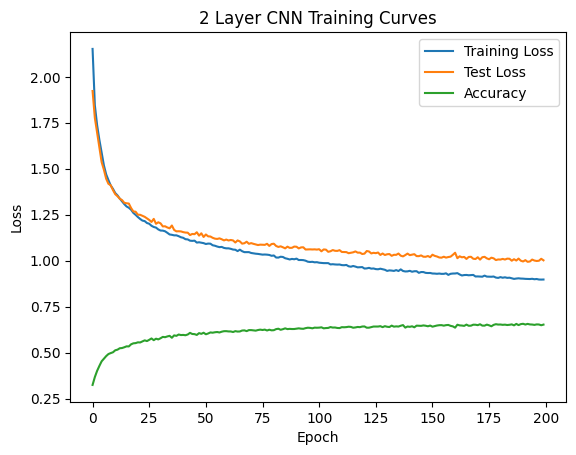

In [24]:
# Batch size of 64 surprisingly gave the best results
workers = 16
cifar10_train = datasets.CIFAR10(data_path, train=True, download=dl, transform=transform)
train_loader = DataLoader(
    cifar10_train,
    batch_size=2048,
    shuffle=True,
    num_workers=workers,
    pin_memory=True,
    prefetch_factor=4
)

cifar10_test = datasets.CIFAR10(data_path, train=False, download=dl, transform=transform)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=True, num_workers=workers, pin_memory=True, prefetch_factor=4)

model_1a = ConvImageClassifier(
    input_dim = 32,
    conv_layers=[16, 8],
    fc_layers=[32, 10],
    activation=nn.ReLU
).to(device=device)
 
print(model_1a.stack)

model_1a.train_model(
    epochs=200,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-3, 'weight_decay': 1e-2},
    print_epoch=1,
    header_epoch=15
)

model_1a.plot_training("2 Layer CNN Training Curves")


In [31]:
train_loader = DataLoader(
    cifar10_train,
    batch_size=1024,
    shuffle=True,
    num_workers=workers,
    prefetch_factor=4
)

model_1b = ConvImageClassifier(
    input_dim = 32,
    conv_layers=[16, 8, 4],
    fc_layers=[32, 10],
    activation=nn.ReLU
).to(device=device)
 
print(model_1a.stack)

model_1b.train_model(
    epochs=200,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer = torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-2, 'weight_decay': 1e-3},
    loss_fn=nn.CrossEntropyLoss(),
    print_epoch=1
)

model_1a.plot_training("3 Layer CNN Training Curves")


Sequential(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation0): ReLU()
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc0): Linear(in_features=512, out_features=32, bias=True)
  (activation_fc1): ReLU()
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)
Training ConvImageClassifier

-------------------------------------------------------------------------------------------------


|     Epoch     |Epoch Time (s) | Training Loss |  Test Loss    |  Overfit (%)  | Accuracy (%)  |
-------------------------------------------------------------------------------------------------
|       0       |    4.40103    |  1.89187307   |  1.60926700   |   -14.93790   |    0.40980    |
-------------------------------------------------------------------------------------------------
